# Anomaly Detection Using Elliptical Distribution

This notebook implements anomaly detection for the Tennessee Eastman Process using elliptical distribution methods.

## Configuration

In [1]:
# Data loading
import pyreadr

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Numerical operations
import numpy as np
import pandas as pd

# Scientific computing
from scipy.linalg import eigh
from scipy import stats
from scipy.spatial.distance import mahalanobis

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Optional, Tuple, Dict, Any, List
from numpy.typing import NDArray

# Utilities
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load R data files
fault_free_training_dict = pyreadr.read_r("data/TEP_FaultFree_Training.RData")
fault_free_testing_dict = pyreadr.read_r("data/TEP_FaultFree_Testing.RData")
faulty_training_dict = pyreadr.read_r("data/TEP_Faulty_Training.RData")
faulty_testing_dict = pyreadr.read_r("data/TEP_Faulty_Testing.RData")

# Extract dataframes
DF_FF_TRAINING_RAW = fault_free_training_dict["fault_free_training"]
DF_FF_TEST_RAW = fault_free_testing_dict["fault_free_testing"]
DF_F_TRAINING_RAW = faulty_training_dict["faulty_training"]
DF_F_TEST_RAW = faulty_testing_dict["faulty_testing"]

In [3]:
# Define columns to remove
TARGET_VARIABLE_COLUMN_NAME = "faultNumber"
SIMULATION_RUN_COLUMN_NAME = "simulationRun"
COLUMNS_TO_REMOVE = ["faultNumber", "simulationRun", "sample"]

# Standardize data
scaler_incontrol = StandardScaler()
X_INCONTROL_TRAIN_FULL_DF = DF_FF_TRAINING_RAW.drop(columns=COLUMNS_TO_REMOVE, axis=1)
scaler_incontrol.fit(X_INCONTROL_TRAIN_FULL_DF)
X_INCONTROL_TRAIN_FULL_SCALED = scaler_incontrol.transform(X_INCONTROL_TRAIN_FULL_DF)

print(f"Training data shape: {X_INCONTROL_TRAIN_FULL_SCALED.shape}")
print(f"Number of features: {X_INCONTROL_TRAIN_FULL_SCALED.shape[1]}")

Training data shape: (250000, 52)
Number of features: 52


## Elliptical Distribution Detector

Implements anomaly detection based on elliptical (multivariate normal) distributions using:
- Mahalanobis distance for measuring deviation from the distribution center
- Chi-square control limits for threshold determination
- Robust covariance estimation options

In [4]:
class EllipticalDistributionDetector:
    """
    Anomaly detector based on elliptical (multivariate normal) distribution.
    
    Uses Mahalanobis distance to measure how far a point deviates from
    the center of the distribution. Points beyond a chi-square threshold
    are flagged as anomalies.
    
    Parameters
    ----------
    alpha : float, default=0.01
        Significance level for control limit (probability of false alarm)
    robust : bool, default=False
        If True, use robust covariance estimation (Minimum Covariance Determinant)
    """
    
    def __init__(self, alpha: float = 0.01, robust: bool = False):
        self.alpha = alpha
        self.robust = robust
        self.mu = None
        self.sigma = None
        self.sigma_inv = None
        self.threshold = None
        self.p = None  # Number of features
        
    def fit(self, X: NDArray) -> 'EllipticalDistributionDetector':
        """
        Fit the elliptical distribution to in-control training data.
        
        Parameters
        ----------
        X : NDArray of shape (n_samples, n_features)
            In-control training data
            
        Returns
        -------
        self : EllipticalDistributionDetector
        """
        n, self.p = X.shape
        
        if self.robust:
            # Robust covariance estimation using MCD
            from sklearn.covariance import MinCovDet
            mcd = MinCovDet().fit(X)
            self.mu = mcd.location_
            self.sigma = mcd.covariance_
        else:
            # Standard maximum likelihood estimation
            self.mu = np.mean(X, axis=0)
            self.sigma = np.cov(X.T)
        
        # Compute inverse covariance for Mahalanobis distance
        self.sigma_inv = np.linalg.inv(self.sigma)
        
        # Set control limit based on chi-square distribution
        # For elliptical distribution, squared Mahalanobis distance ~ chi-square(p)
        self.threshold = stats.chi2.ppf(1 - self.alpha, df=self.p)
        
        return self
    
    def _mahalanobis_distance(self, X: NDArray) -> NDArray:
        """
        Compute Mahalanobis distance for each sample.
        
        Parameters
        ----------
        X : NDArray of shape (n_samples, n_features)
            Test data
            
        Returns
        -------
        distances : NDArray of shape (n_samples,)
            Squared Mahalanobis distances
        """
        # Center the data
        X_centered = X - self.mu
        
        # Compute squared Mahalanobis distance: (x - mu)^T Sigma^-1 (x - mu)
        distances = np.sum(X_centered @ self.sigma_inv * X_centered, axis=1)
        
        return distances
    
    def predict(self, X: NDArray) -> NDArray:
        """
        Predict anomaly labels for test data.
        
        Parameters
        ----------
        X : NDArray of shape (n_samples, n_features)
            Test data
            
        Returns
        -------
        flags : NDArray of shape (n_samples,)
            Binary flags (0=normal, 1=anomaly)
        """
        # Compute Mahalanobis distances
        distances = self._mahalanobis_distance(X)
        
        # Flag samples exceeding threshold as anomalies
        flags = (distances > self.threshold).astype(int)
        
        return flags
    
    def score(self, X: NDArray) -> NDArray:
        """
        Return anomaly scores (Mahalanobis distances) for test data.
        
        Parameters
        ----------
        X : NDArray of shape (n_samples, n_features)
            Test data
            
        Returns
        -------
        scores : NDArray of shape (n_samples,)
            Squared Mahalanobis distances
        """
        return self._mahalanobis_distance(X)

## Robust Elliptical Distribution Detector

An alternative implementation using robust covariance estimation to handle outliers in training data.

In [5]:
class RobustEllipticalDetector(EllipticalDistributionDetector):
    """
    Robust version of elliptical distribution detector.
    Uses Minimum Covariance Determinant (MCD) for parameter estimation.
    """
    
    def __init__(self, alpha: float = 0.01):
        super().__init__(alpha=alpha, robust=True)

## T-squared Control Chart

Hotelling's T² statistic, a classic multivariate control chart based on elliptical distribution.

In [6]:
class HotellingT2Detector:
    """
    Hotelling's T² control chart for multivariate anomaly detection.
    
    This is a classic statistical process control method based on
    the elliptical (multivariate normal) distribution.
    
    Parameters
    ----------
    alpha : float, default=0.01
        Significance level for control limit
    phase : int, default=2
        Phase 1 (estimation) or Phase 2 (monitoring)
    """
    
    def __init__(self, alpha: float = 0.01, phase: int = 2):
        self.alpha = alpha
        self.phase = phase
        self.mu = None
        self.sigma = None
        self.sigma_inv = None
        self.threshold = None
        self.n = None  # Training sample size
        self.p = None  # Number of features
        
    def fit(self, X: NDArray) -> 'HotellingT2Detector':
        """
        Fit Hotelling's T² detector to in-control training data.
        
        Parameters
        ----------
        X : NDArray of shape (n_samples, n_features)
            In-control training data
            
        Returns
        -------
        self : HotellingT2Detector
        """
        self.n, self.p = X.shape
        
        # Estimate parameters
        self.mu = np.mean(X, axis=0)
        self.sigma = np.cov(X.T)
        self.sigma_inv = np.linalg.inv(self.sigma)
        
        # Set control limit based on phase
        if self.phase == 1:
            # Phase I: Use Beta distribution
            # T² ~ (n-1)²/n * Beta(p/2, (n-p-1)/2)
            beta_quantile = stats.beta.ppf(
                1 - self.alpha, 
                self.p / 2, 
                (self.n - self.p - 1) / 2
            )
            self.threshold = ((self.n - 1) ** 2 / self.n) * beta_quantile
        else:
            # Phase II: Use F distribution
            # T² ~ (p(n+1)(n-1))/(n(n-p)) * F(p, n-p)
            f_quantile = stats.f.ppf(1 - self.alpha, self.p, self.n - self.p)
            self.threshold = (self.p * (self.n + 1) * (self.n - 1)) / (self.n * (self.n - self.p)) * f_quantile
        
        return self
    
    def _compute_t2(self, X: NDArray) -> NDArray:
        """
        Compute Hotelling's T² statistic for each sample.
        
        Parameters
        ----------
        X : NDArray of shape (n_samples, n_features)
            Test data
            
        Returns
        -------
        t2_stats : NDArray of shape (n_samples,)
            T² statistics
        """
        # Center the data
        X_centered = X - self.mu
        
        # Compute T² = n * (x - mu)^T S^-1 (x - mu)
        t2_stats = self.n * np.sum(X_centered @ self.sigma_inv * X_centered, axis=1)
        
        return t2_stats
    
    def predict(self, X: NDArray) -> NDArray:
        """
        Predict anomaly labels for test data.
        
        Parameters
        ----------
        X : NDArray of shape (n_samples, n_features)
            Test data
            
        Returns
        -------
        flags : NDArray of shape (n_samples,)
            Binary flags (0=normal, 1=anomaly)
        """
        # Compute T² statistics
        t2_stats = self._compute_t2(X)
        
        # Flag samples exceeding threshold as anomalies
        flags = (t2_stats > self.threshold).astype(int)
        
        return flags
    
    def score(self, X: NDArray) -> NDArray:
        """
        Return T² statistics for test data.
        
        Parameters
        ----------
        X : NDArray of shape (n_samples, n_features)
            Test data
            
        Returns
        -------
        scores : NDArray of shape (n_samples,)
            T² statistics
        """
        return self._compute_t2(X)

## Initialize Detectors

In [7]:
# Initialize different elliptical distribution detectors
elliptical_detector = EllipticalDistributionDetector(alpha=0.01, robust=False)
robust_elliptical_detector = RobustEllipticalDetector(alpha=0.01)
hotelling_t2_detector = HotellingT2Detector(alpha=0.01, phase=2)

# Fit all detectors
elliptical_detector.fit(X_INCONTROL_TRAIN_FULL_SCALED)
robust_elliptical_detector.fit(X_INCONTROL_TRAIN_FULL_SCALED)
hotelling_t2_detector.fit(X_INCONTROL_TRAIN_FULL_SCALED)

print("All detectors fitted successfully!")
print(f"Elliptical detector threshold: {elliptical_detector.threshold:.2f}")
print(f"Robust elliptical detector threshold: {robust_elliptical_detector.threshold:.2f}")
print(f"Hotelling T² detector threshold: {hotelling_t2_detector.threshold:.2f}")

All detectors fitted successfully!
Elliptical detector threshold: 78.62
Robust elliptical detector threshold: 78.62
Hotelling T² detector threshold: 78.64


## Evaluation Functions

In [8]:
def get_first_false_alarm_index(flags_normal: NDArray) -> Optional[int]:
    """
    Get the index of the first false alarm in in-control data.
    
    Parameters
    ----------
    flags_normal : NDArray
        Binary flags for in-control data
        
    Returns
    -------
    index : int or None
        Index of first false alarm, or None if no false alarms
    """
    if np.any(flags_normal == 1):
        return int(np.argmax(flags_normal == 1))
    return None


def get_first_detection_delay(flags_anomaly: NDArray) -> Optional[int]:
    """
    Get the detection delay (index of first detection) for anomaly data.
    
    Parameters
    ----------
    flags_anomaly : NDArray
        Binary flags for anomaly data
        
    Returns
    -------
    delay : int or None
        Index of first detection, or None if no detection
    """
    if np.any(flags_anomaly == 1):
        return int(np.argmax(flags_anomaly == 1))
    return None

## Run with all samples

In [9]:
SIMULATION_RUN_RANGE = range(1, 21)  # 20 simulation runs
FAULT_NUMBER_RANGE = range(1, 21)    # 20 fault types
fault_injection_point = 160

results = []

MODELS = {
    "Elliptical": elliptical_detector.predict,
    "RobustElliptical": robust_elliptical_detector.predict,
    "HotellingT2": hotelling_t2_detector.predict,
}

for simulation_run in SIMULATION_RUN_RANGE:
    print(f"Processing simulation run {simulation_run}...")
    
    # Prepare in-control test data (fault-free)
    X_INCONTROL_TEST_DF = DF_FF_TEST_RAW[
        DF_FF_TEST_RAW[SIMULATION_RUN_COLUMN_NAME] == simulation_run
    ].drop(columns=COLUMNS_TO_REMOVE, axis=1)
    
    X_INCONTROL_TEST_DF = X_INCONTROL_TEST_DF.iloc[fault_injection_point:]
    X_INCONTROL_TEST_SCALED = scaler_incontrol.transform(X_INCONTROL_TEST_DF)
    
    for fault_number in FAULT_NUMBER_RANGE:
        # Prepare out-of-control test data (faulty)
        X_OUT_OF_CONTROL_TEST_DF = DF_F_TEST_RAW[
            (DF_F_TEST_RAW[SIMULATION_RUN_COLUMN_NAME] == simulation_run) &
            (DF_F_TEST_RAW[TARGET_VARIABLE_COLUMN_NAME] == fault_number)
        ].drop(columns=COLUMNS_TO_REMOVE, axis=1)
        
        X_OUT_OF_CONTROL_TEST_DF = X_OUT_OF_CONTROL_TEST_DF.iloc[fault_injection_point:]
        X_OUT_OF_CONTROL_TEST_SCALED = scaler_incontrol.transform(X_OUT_OF_CONTROL_TEST_DF)
        
        for model_name, model_func in MODELS.items():
            # Run prediction
            pred_anomaly = model_func(X_OUT_OF_CONTROL_TEST_SCALED)
            pred_normal = model_func(X_INCONTROL_TEST_SCALED)
            
            # Calculate metrics
            arl1 = get_first_detection_delay(pred_anomaly)
            arl0 = get_first_false_alarm_index(pred_normal)
            detection_fraction = np.mean(pred_anomaly)
            
            # Store results
            results.append({
                "simulationRun": simulation_run,
                "faultNumber": fault_number,
                "model": model_name,
                "ARL0": arl0,
                "ARL1": arl1,
                "detection_fraction": detection_fraction
            })

print("Evaluation complete!")

Processing simulation run 1...
Processing simulation run 2...
Processing simulation run 3...
Processing simulation run 4...
Processing simulation run 5...
Processing simulation run 6...
Processing simulation run 7...
Processing simulation run 8...
Processing simulation run 9...
Processing simulation run 10...
Processing simulation run 11...
Processing simulation run 12...
Processing simulation run 13...
Processing simulation run 14...
Processing simulation run 15...
Processing simulation run 16...
Processing simulation run 17...
Processing simulation run 18...
Processing simulation run 19...
Processing simulation run 20...
Evaluation complete!


## Results Analysis

In [10]:
# Convert to DataFrame
df_results = pd.DataFrame(results)

# Group by model and fault number
grouped = df_results.groupby(['model', 'faultNumber'])

# Compute summary statistics
summary_df = pd.DataFrame({
    'conditional_ARL0': grouped['ARL0'].apply(lambda x: x.dropna().mean()),
    'SDRL0': grouped['ARL0'].apply(lambda x: x.dropna().std()),
    'non_FA_fraction': grouped['ARL0'].apply(lambda x: x.isnull().mean()),
    'conditional_ARL1': grouped['ARL1'].apply(lambda x: x.dropna().mean()),
    'SDRL1': grouped['ARL1'].apply(lambda x: x.dropna().std()),
    'non_detection_fraction': grouped['ARL1'].apply(lambda x: x.isnull().mean()),
    'avg_detection_fraction': grouped['detection_fraction'].mean()
}).reset_index()

print("Summary Results:")
summary_df.head(20)

Summary Results:


,model,faultNumber,conditional_ARL0,SDRL0,non_FA_fraction,conditional_ARL1,SDRL1,non_detection_fraction,avg_detection_fraction
0,Elliptical,1,145.7,121.585621,0.0,1.80,0.695852,0.0,0.997750
1,Elliptical,2,145.7,121.585621,0.0,8.10,3.160613,0.0,0.988625
2,Elliptical,3,145.7,121.585621,0.0,129.10,122.844746,0.0,0.012125
3,Elliptical,4,145.7,121.585621,0.0,0.00,0.000000,0.0,0.999812
4,Elliptical,5,145.7,121.585621,0.0,0.00,0.000000,0.0,1.000000
5,Elliptical,6,145.7,121.585621,0.0,0.00,0.000000,0.0,1.000000
6,Elliptical,7,145.7,121.585621,0.0,0.00,0.000000,0.0,1.000000
7,Elliptical,8,145.7,121.585621,0.0,17.10,9.759745,0.0,0.972438
8,Elliptical,9,145.7,121.585621,0.0,130.65,125.005800,0.0,0.012750
9,Elliptical,10,145.7,121.585621,0.0,20.65,14.042323,0.0,0.857938


In [11]:
# Overall performance by model
overall_summary = df_results.groupby('model').agg({
    'ARL0': lambda x: x.dropna().mean(),
    'ARL1': lambda x: x.dropna().mean(),
    'detection_fraction': 'mean'
})

print("\nOverall Model Performance:")
overall_summary


Overall Model Performance:


,ARL0,ARL1,detection_fraction
model,,,
Elliptical,145.70,27.100,0.810150
HotellingT2,0.00,0.000,1.000000
RobustElliptical,113.95,23.135,0.812078


## Visualization

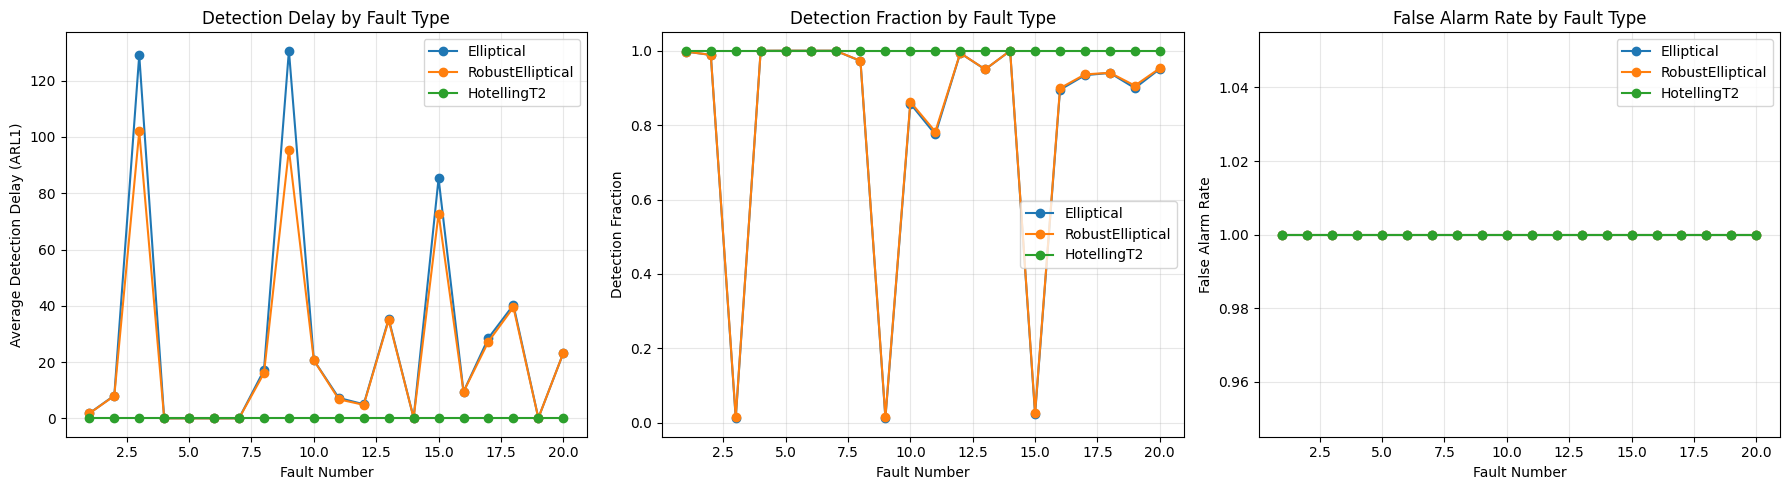

In [12]:
# Plot detection performance by fault type
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ARL1 (Detection Delay)
for model in MODELS.keys():
    model_data = summary_df[summary_df['model'] == model]
    axes[0].plot(model_data['faultNumber'], model_data['conditional_ARL1'], 
                 marker='o', label=model)
axes[0].set_xlabel('Fault Number')
axes[0].set_ylabel('Average Detection Delay (ARL1)')
axes[0].set_title('Detection Delay by Fault Type')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Detection Fraction
for model in MODELS.keys():
    model_data = summary_df[summary_df['model'] == model]
    axes[1].plot(model_data['faultNumber'], model_data['avg_detection_fraction'], 
                 marker='o', label=model)
axes[1].set_xlabel('Fault Number')
axes[1].set_ylabel('Detection Fraction')
axes[1].set_title('Detection Fraction by Fault Type')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# False Alarm Rate
for model in MODELS.keys():
    model_data = summary_df[summary_df['model'] == model]
    fa_rate = 1 - model_data['non_FA_fraction']
    axes[2].plot(model_data['faultNumber'], fa_rate, marker='o', label=model)
axes[2].set_xlabel('Fault Number')
axes[2].set_ylabel('False Alarm Rate')
axes[2].set_title('False Alarm Rate by Fault Type')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

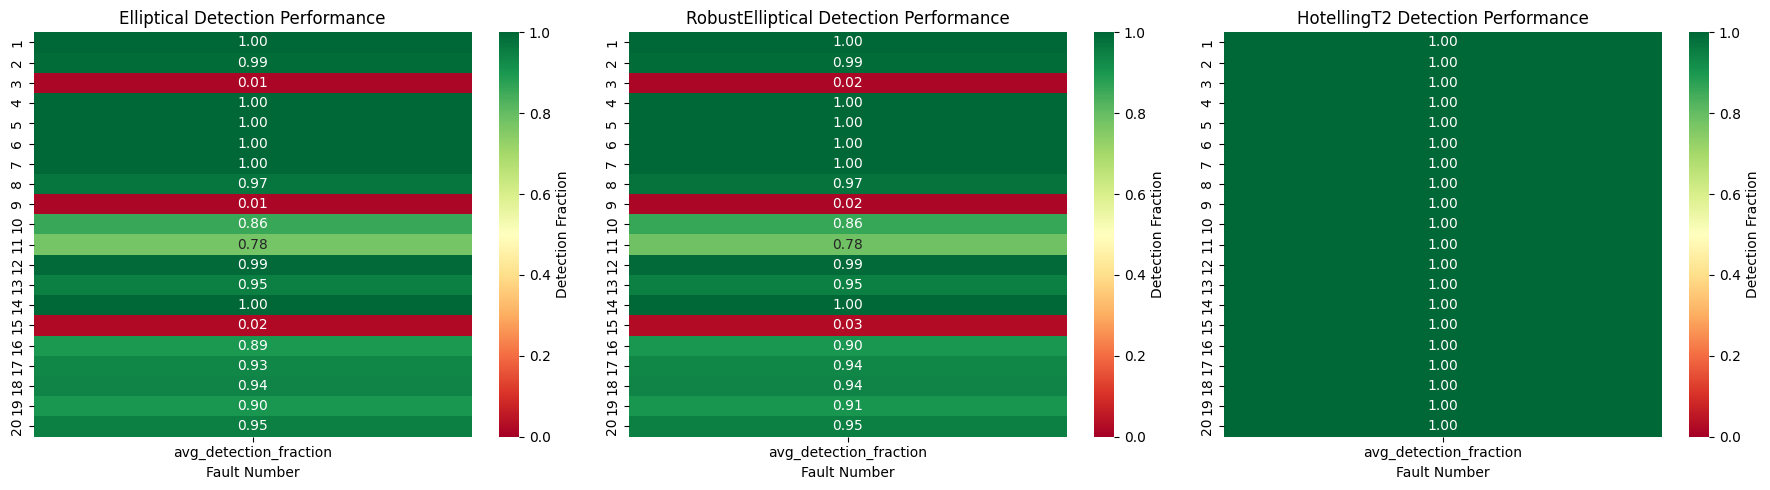

In [13]:
# Heatmap of detection performance
fig, axes = plt.subplots(1, len(MODELS), figsize=(6*len(MODELS), 5))

for idx, model in enumerate(MODELS.keys()):
    model_data = summary_df[summary_df['model'] == model]
    pivot_data = model_data.pivot_table(
        values='avg_detection_fraction',
        index='faultNumber',
        aggfunc='mean'
    )
    
    ax = axes[idx] if len(MODELS) > 1 else axes
    sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn', 
                vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Detection Fraction'})
    ax.set_title(f'{model} Detection Performance')
    ax.set_xlabel('Fault Number')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

## Save Results

In [14]:
# Save detailed results
df_results.to_csv('elliptical_distribution_results.csv', index=False)
summary_df.to_csv('elliptical_distribution_summary.csv', index=False)

print("Results saved to CSV files!")

Results saved to CSV files!
